In [2]:
import sys
import os
from os.path import split, join
base_dir = split(os.getcwd())[0]
if base_dir not in sys.path:
    sys.path.append(base_dir)
from utilities.basic import list_subdir
from utilities import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import pickle
import json

In [16]:
data_dir = join(base_dir, 'data')
tables_dir = join(data_dir, 'tables')
data_long_dir = join(data_dir, 't1_longitudinal')
disk_dir = "F:\\"
fig_dir = join(base_dir, 't1_long','figs')
br_df = pd.read_csv(join(disk_dir,"CoBra\\Data\\volume_longitudinal_nii\\Brain_Regions.csv"))
pred_dir = join(disk_dir, "CoBra\\Data\\volume_longitudinal_nii\\prediction")
df_pat = utils.load_scan_csv(join(tables_dir, 'neg_pos_clean.csv'))
pred_df = pd.read_feather(join(data_long_dir, 'results', 'volume_prediction_results.feather'))
with open(join(data_long_dir, "sids_long_new.pkl"), 'rb') as f:
    long_sids_ls = pickle.load(f)
with open(join(data_long_dir, "sids_long_stroke.pkl"), 'rb') as f:
    stroke_sids_ls = pickle.load(f)
with open(join(tables_dir, 'newIDs_dic.pkl'), 'rb') as f:
    id_dic = pickle.load(f)
with open(join(data_long_dir, "sids_long_new.pkl"), 'rb') as f:
    sids_ls = pickle.load(f)
with open(join(tables_dir, "disk_series_directories.json"), 'rb') as f:
    dir_dic = json.load(f)
inv_id_map = {v: k for k, v in id_dic.items()}
#dcm_dirs = {newid:os.path.normpath(dir_dic[inv_id_map[newid]]) for newid in newids}

df = pred_df[pred_df.SeriesInstanceUID.isin(long_sids_ls)]
corrected_outliers = ['109983', '047205', '083072', '109644', '287546', '258402',
                '258387', '258391', '258394','258397','258402', '258403']
rerun_conversion_files = ['109983', '047205', '083072', '109644', '287546',]

C:\Users\kiril\.conda\envs\cobra\lib\site-packages\ipykernel_launcher.py:8: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  


In [4]:
len(long_sids_ls)

2854

In [5]:
# pred_df = pred_df[~pred_df.newID.isin(corrected_outliers)]
# pred_df = pred_df.reset_index(drop=True)
# pred_df.to_feather(join(data_long_dir,'results', 'volume_prediction_results.feather'))

## Segmented brain regions

## Whole brain volume dist

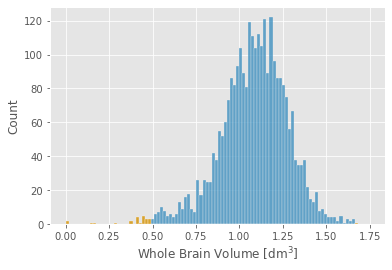

In [17]:
plt.style.use('ggplot')
fig, ax = plt.subplots()
_,bins = np.histogram(df.Whole_Brain, bins=100, range=(0,1.75))
sns.histplot(df.Whole_Brain/1e6, ax=ax, bins=bins)
sns.histplot(df[np.abs(stats.zscore(df.Whole_Brain)) > 3].Whole_Brain/1e6,bins=bins, ax=ax, color='orange')
ax.set_xlabel('Whole Brain Volume '+r'$[\mathrm{dm}^3]$')
fig.savefig(join(fig_dir, "whole_brain_dist.png"), dpi=200)

<AxesSubplot:ylabel='Whole_Brain'>

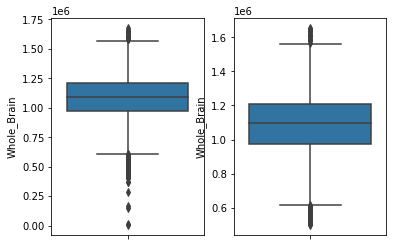

In [168]:
fig, ax = plt.subplots(1,2)
sns.boxplot(data = df, y='Whole_Brain', ax=ax[0])
sns.boxplot(data = df[np.abs(stats.zscore(df.Whole_Brain)) < 3], y='Whole_Brain', ax=ax[1])

## Outliers

In [123]:
wb_outliers_df = pred_df[np.abs(stats.zscore(pred_df.Whole_Brain)) > 3]
outliers_ids = list(wb_outliers_df.newID)


corr_sids_ls = [inv_id_map[id] for id in outliers_ids]
dcm_dirs = {sid:os.path.normpath(dir_dic[sid]) for sid in corr_sids_ls}
outliers_sids = [inv_id_map[id] for id in outliers_ids]
print(len(outliers_ids))
#print(outliers_sids)

105


In [22]:
failed_seg_paths = [(join(pred_dir, id+'_1mm.nii.gz'), join(pred_dir, id+'_1mm_seg.nii.gz')) for id in outliers_ids]
with open(join(data_long_dir, "failed_seg.pkl"), 'wb') as f:
    pickle.dump(failed_seg_paths, f)

## Brain regions of interest

In [191]:
get_br_ls('Ope')

[]

In [199]:
br_ls = list(df.keys())
br_ls.remove('newID')
br_ls.remove('SeriesInstanceUID')
def get_br_ls(key=''):
    if not(isinstance(key, list)):
        ls = [f for f in br_ls if key in f]
        return ls
    else:
        ls = [f for f in br_ls if key[0] in f]
        for k in key:
            ls = [f for f in ls if k in f]
        return ls

In [200]:
get_br_ls('Op')

['Right_Central_Operculum',
 'Right_Frontal_Operculum',
 'Right_Opercular_Inferior_Frontal_Gyrus',
 'Right_Parietal_Operculum',
 'Left_Central_Operculum',
 'Left_Frontal_Operculum',
 'Left_Opercular_Inferior_Frontal_Gyrus',
 'Left_Parietal_Operculum']

In [201]:
affected_br_dic = {
    'left rolandic operculum':get_br_ls('Op'),
    'olfactory bulb':[], 
    'bilateral insulas':get_br_ls('Insu'),
    'bilateral hipocampi':get_br_ls('Hip'),
    'right cingulate gyrus':get_br_ls(['Cing', 'Right']),
    'left heschls gyrus':get_br_ls(['Trans', 'Left']),
    'parahippocampal gyrus':get_br_ls('Para'),
    'anterior cingulate cortex':get_br_ls('Anterior_Cingulate'),
    'temporal pole':get_br_ls('Temporal_Pole'),
    'left orbitofrontal cortex':['Left_Posterior_Orbital_Gyrus', 
        'Left_Medial_Orbital_Gyrus','Left_Lateral_Orbital_Gyrus',
        'Left_Anterior_Orbital_Gyrus']
    }


In [204]:
print(list(affected_br_dic.keys()))

['left rolandic operculum', 'olfactory bulb', 'bilateral insulas', 'bilateral hipocampi', 'right cingulate gyrus', 'left heschls gyrus', 'parahippocampal gyrus', 'anterior cingulate cortex', 'temporal pole', 'left orbitofrontal cortex']


### Check outliers for every brain region

In [148]:
exclude_sids_ls = []
for br_ls in affected_br_dic.values():
    for br in br_ls:
        exclude_sids_ls = exclude_sids_ls + df[np.abs(stats.zscore(df[br])) > 3].SeriesInstanceUID.to_list()

In [150]:
exclude_sids_ls = list(set(exclude_sids_ls))

In [160]:
with open(join(data_long_dir, "outliers_affected_br.txt"), 'w') as f:
    for listitem in exclude_sids_ls:
        f.write('%s\n' % listitem)

## How many patients are affected

In [158]:
df_pat[df_pat.SeriesInstanceUID.isin(exclude_sids_ls)].PatientID.nunique()

153

In [153]:
with open(join(data_long_dir, "outliers_affected_br.pkl"), 'wb') as f:
    pickle.dump(exclude_sids_ls, f)